## **Final Project 2 (Klasifikasi gambar)**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unggah kaggle.json
from google.colab import files
files.upload()  # Pilih file kaggle.json yang telah diunduh

# Buat direktori kaggle dan pindahkan kaggle.json ke sana
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instal kaggle API
!pip install kaggle

# Unduh dataset yang diinginkan
!kaggle datasets download -d husnid/a-database-of-leaf-images

# Ekstrak dataset ke direktori saat ini
import zipfile

with zipfile.ZipFile('a-database-of-leaf-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Memeriksa isi direktori dataset
import os
print("Files in dataset directory:")
print(os.listdir('/content/dataset'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving a-database-of-leaf-images-metadata.json to a-database-of-leaf-images-metadata (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
403 - Forbidden - Permission 'datasets.get' was denied


FileNotFoundError: [Errno 2] No such file or directory: 'a-database-of-leaf-images.zip'

In [ ]:
import os

# Periksa struktur direktori dataset
root_dir = '/content/dataset/A Database of Leaf Images'
corrected_dir = '/content/dataset/leaf_images'
os.makedirs(corrected_dir, exist_ok=True)

# Pindahkan gambar ke direktori yang benar
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for sub_class_name in os.listdir(class_dir):
            sub_class_dir = os.path.join(class_dir, sub_class_name)
            if os.path.isdir(sub_class_dir):
                new_sub_class_dir = os.path.join(corrected_dir, sub_class_name)
                os.makedirs(new_sub_class_dir, exist_ok=True)
                for img_name in os.listdir(sub_class_dir):
                    img_path = os.path.join(sub_class_dir, img_name)
                    if os.path.isfile(img_path):
                        new_img_path = os.path.join(new_sub_class_dir, f"{class_name}_{img_name}")
                        os.rename(img_path, new_img_path)

print("Struktur direktori setelah diperbaiki:")
for root, dirs, files in os.walk(corrected_dir):
    print(root, dirs, len(files))


Struktur direktori setelah diperbaiki:
/content/dataset/leaf_images ['Lemon (P10)', 'diseased', 'Jatropha (P6)', 'healthy', 'Pomegranate (P9)', 'Pongamia Pinnata (P7)', 'Chinar (P11)', 'Gauva (P3)', 'Alstonia Scholaris (P2)', 'Jamun (P5)', 'Mango (P0)', 'Arjun (P1)'] 0
/content/dataset/leaf_images/Lemon (P10) [] 0
/content/dataset/leaf_images/diseased [] 2107
/content/dataset/leaf_images/Jatropha (P6) [] 0
/content/dataset/leaf_images/healthy [] 2129
/content/dataset/leaf_images/Pomegranate (P9) [] 0
/content/dataset/leaf_images/Pongamia Pinnata (P7) [] 0
/content/dataset/leaf_images/Chinar (P11) [] 0
/content/dataset/leaf_images/Gauva (P3) [] 0
/content/dataset/leaf_images/Alstonia Scholaris (P2) [] 0
/content/dataset/leaf_images/Jamun (P5) [] 0
/content/dataset/leaf_images/Mango (P0) [] 0
/content/dataset/leaf_images/Arjun (P1) [] 0


In [ ]:
# Preprocessing dan Augmentasi Data
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             horizontal_flip=True,
                             validation_split=0.2)  # Membagi data untuk validasi

# Load dan augmentasi data
def load_data(image_dir, target_size=(128, 128), batch_size=32):
    train_generator = datagen.flow_from_directory(image_dir,
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode='sparse',
                                                  subset='training')

    validation_generator = datagen.flow_from_directory(image_dir,
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='sparse',
                                                       subset='validation')
    return train_generator, validation_generator

image_dir = corrected_dir  # Sesuaikan dengan direktori dataset yang sudah diperbaiki
train_generator, validation_generator = load_data(image_dir)

Found 3390 images belonging to 12 classes.
Found 846 images belonging to 12 classes.


In [ ]:
# Ambil data dari generator dan gabungkan menjadi satu array
def generator_to_array(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        batch_images, batch_labels = generator.next()
        images.extend(batch_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

X_train, y_train = generator_to_array(train_generator)
X_test, y_test = generator_to_array(validation_generator)

# Flatten images for model input
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

K-NN (k=3, Metric=euclidean):
              precision    recall  f1-score   support

        10.0       0.49      0.31      0.38       421
        11.0       0.50      0.68      0.58       425

    accuracy                           0.50       846
   macro avg       0.50      0.50      0.48       846
weighted avg       0.50      0.50      0.48       846



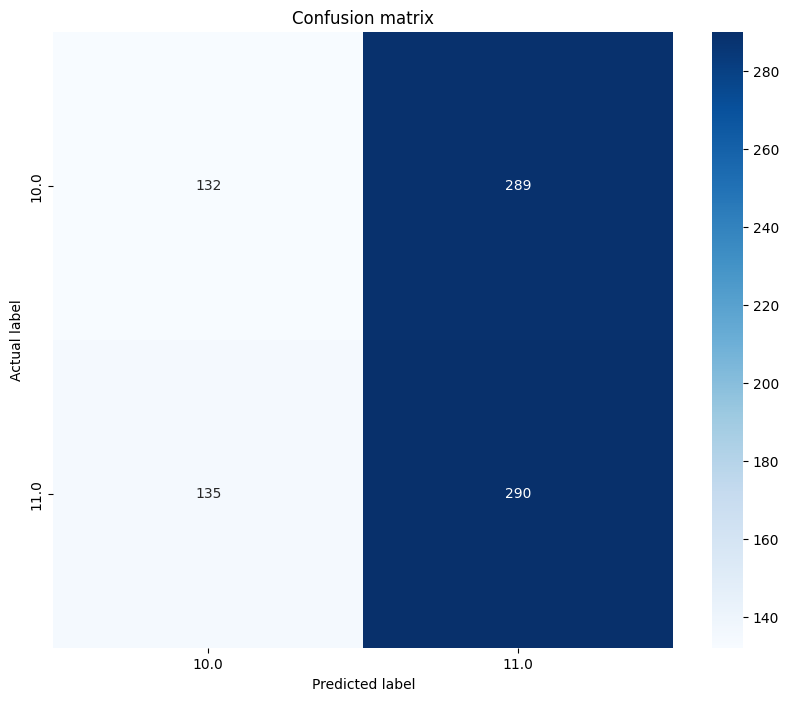

K-NN (k=5, Metric=manhattan):
              precision    recall  f1-score   support

        10.0       0.42      0.22      0.29       421
        11.0       0.48      0.71      0.57       425

    accuracy                           0.46       846
   macro avg       0.45      0.46      0.43       846
weighted avg       0.45      0.46      0.43       846



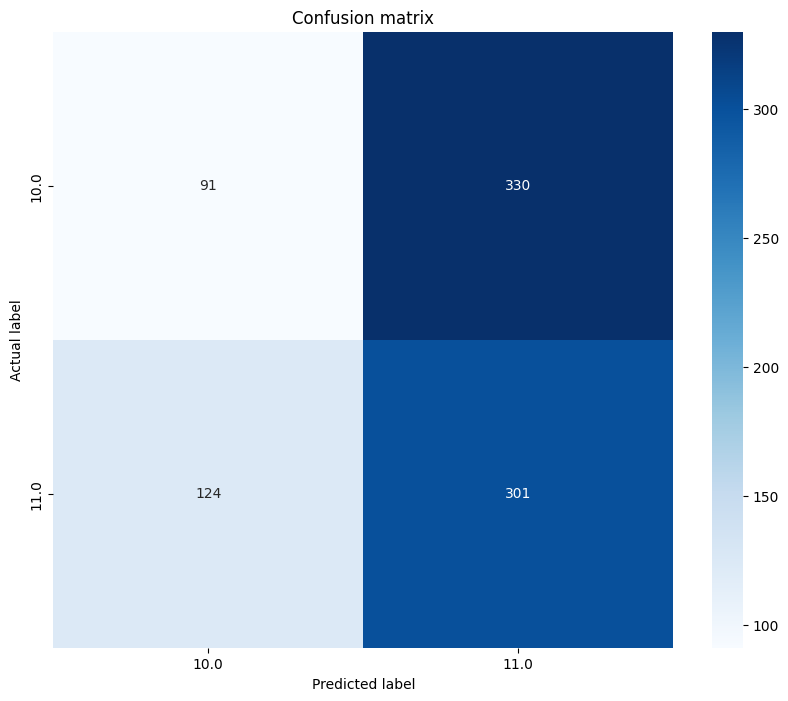

K-NN (k=7, Metric=minkowski):
              precision    recall  f1-score   support

        10.0       0.46      0.28      0.35       421
        11.0       0.49      0.68      0.57       425

    accuracy                           0.48       846
   macro avg       0.47      0.48      0.46       846
weighted avg       0.47      0.48      0.46       846



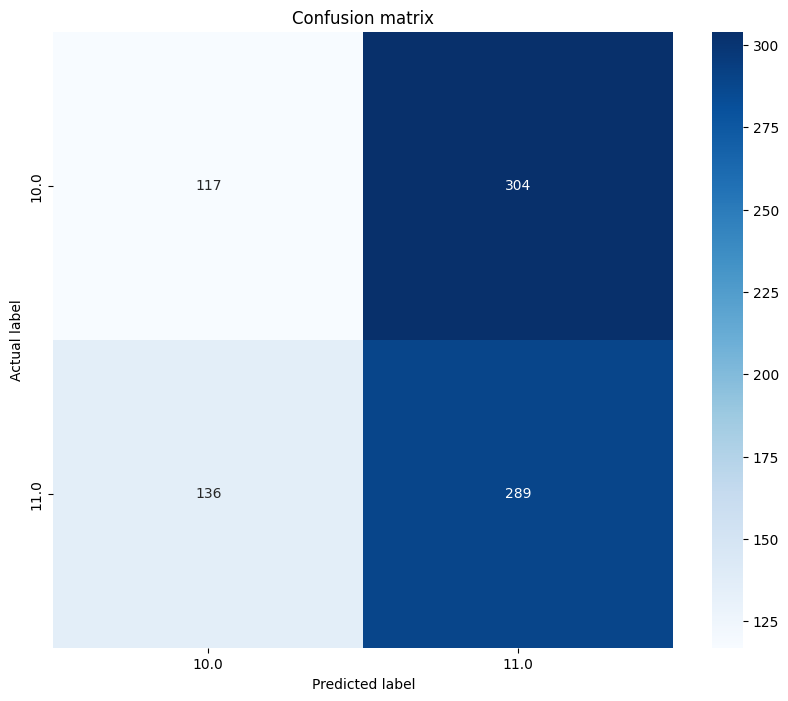

In [ ]:
# Implementasi K-NN
knn_combinations = [
    {'n_neighbors': 3, 'metric': 'euclidean'},
    {'n_neighbors': 5, 'metric': 'manhattan'},
    {'n_neighbors': 7, 'metric': 'minkowski'}
]

for params in knn_combinations:
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    knn.fit(X_train_flatten, y_train)
    y_pred_knn = knn.predict(X_test_flatten)
    print(f"K-NN (k={params['n_neighbors']}, Metric={params['metric']}):")
    print(classification_report(y_test, y_pred_knn))
    plot_confusion_matrix(y_test, y_pred_knn, classes=np.unique(y_train))

SVM (Kernel=linear):
              precision    recall  f1-score   support

        10.0       0.49      0.48      0.48       421
        11.0       0.49      0.50      0.50       425

    accuracy                           0.49       846
   macro avg       0.49      0.49      0.49       846
weighted avg       0.49      0.49      0.49       846



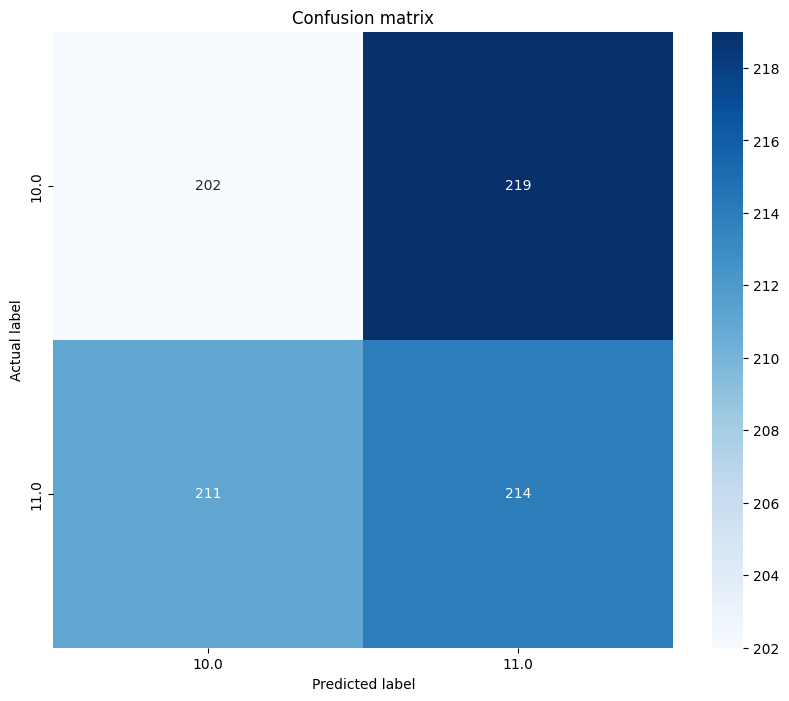

SVM (Kernel=poly):
              precision    recall  f1-score   support

        10.0       0.65      0.46      0.54       421
        11.0       0.59      0.75      0.66       425

    accuracy                           0.61       846
   macro avg       0.62      0.61      0.60       846
weighted avg       0.62      0.61      0.60       846



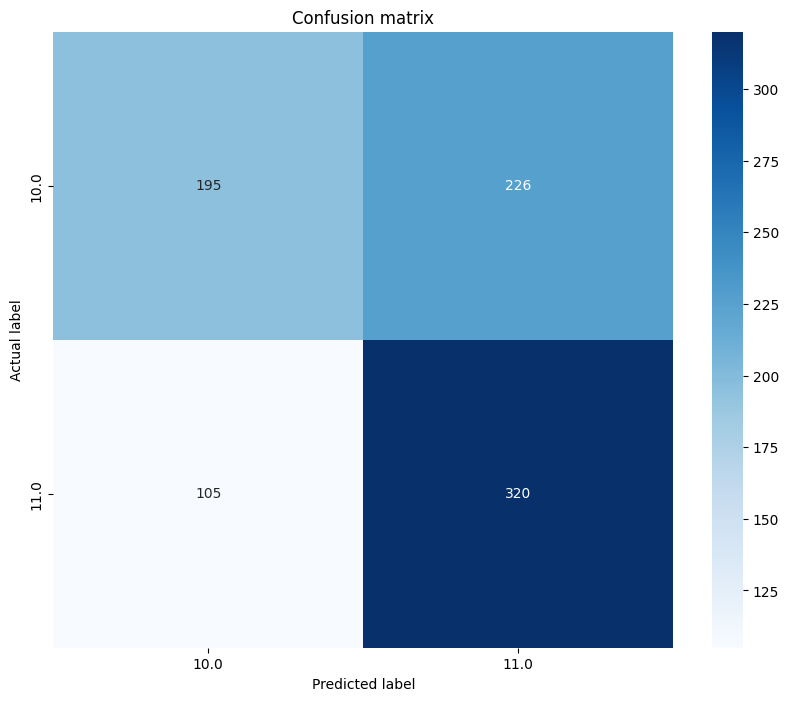

SVM (Kernel=rbf):
              precision    recall  f1-score   support

        10.0       0.51      0.43      0.47       421
        11.0       0.51      0.59      0.55       425

    accuracy                           0.51       846
   macro avg       0.51      0.51      0.51       846
weighted avg       0.51      0.51      0.51       846



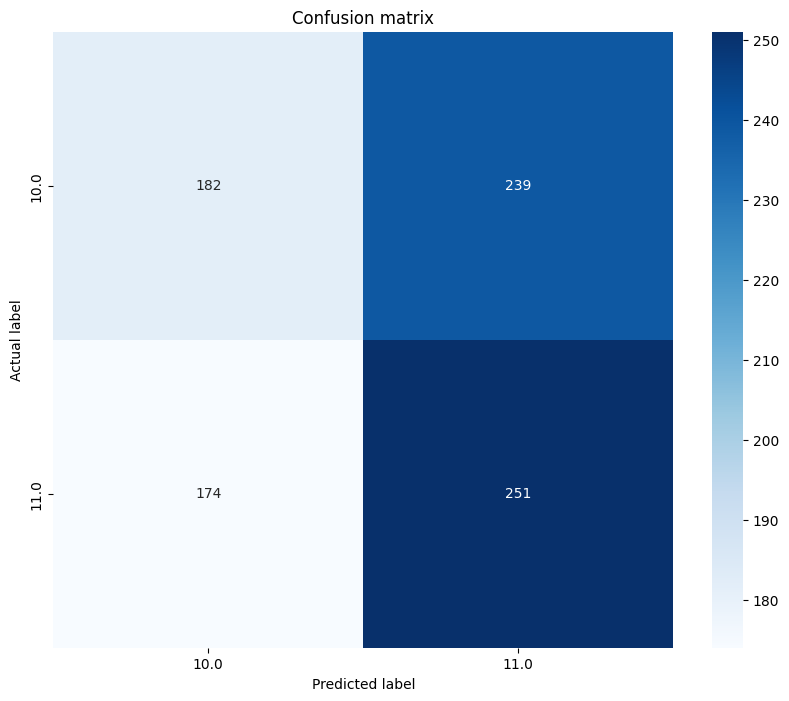

In [ ]:
# Implementasi SVM
svm_kernels = ['linear', 'poly', 'rbf']

for kernel in svm_kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train_flatten, y_train)
    y_pred_svm = svm.predict(X_test_flatten)
    print(f"SVM (Kernel={kernel}):")
    print(classification_report(y_test, y_pred_svm))
    plot_confusion_matrix(y_test, y_pred_svm, classes=np.unique(y_train))

No images found in class: Pomegranate (P9)_healthy
No images found in class: Alstonia Scholaris (P2)_healthy
No images found in class: Chinar (P11)_healthy
No images found in class: Jatropha (P6)_healthy
No images found in class: Mango (P0)_healthy


IsADirectoryError: [Errno 21] Is a directory: '/content/dataset/leaf_images_corrected/Lemon (P10)/diseased'

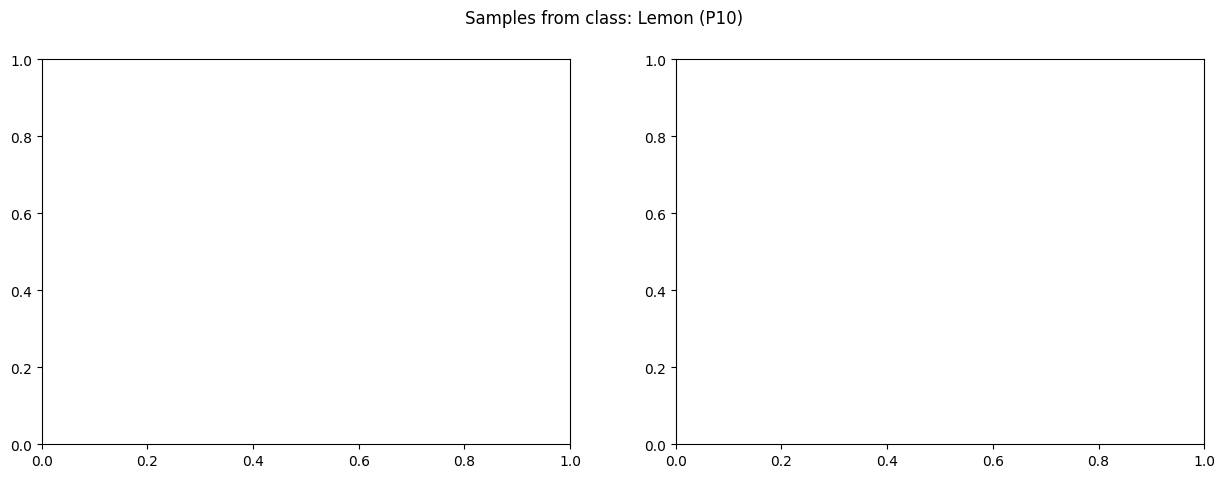

In [ ]:
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def visualize_samples(directory, samples_per_class=5):
    for condition in os.listdir(directory):
        condition_dir = os.path.join(directory, condition)
        if os.path.isdir(condition_dir):
            images = os.listdir(condition_dir)
            if len(images) == 0:
                print(f"No images found in class: {condition}")
                continue
            random_images = random.sample(images, min(samples_per_class, len(images)))
            fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))
            fig.suptitle(f'Samples from class: {condition}')
            for img_name, ax in zip(random_images, axes):
                img_path = os.path.join(condition_dir, img_name)
                img = load_img(img_path, target_size=(128, 128))
                ax.imshow(img)
                ax.axis('off')
            plt.show()

visualize_samples(corrected_dir)
